# Google Earth Engine (GEE) DisALEXI 
## Single Landsat Collection 1 SR Image Example

Example of calling the GEE DisALEXI function on a single Landsat 8 Collection 1 surface
 reflectance image.

### Python imports and GEE initialization

In [1]:
import pprint

import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

%load_ext autoreload
%autoreload 2

pp = pprint.PrettyPrinter(indent=2)

In [2]:
test_xy = [-114.986, 32.355]
test_geom = ee.Geometry.Point(test_xy)

test_region = [[-115.1, 32.3], [-115.1, 32.41], [-114.9, 32.41], [-114.9, 32.3]]
test_geom = ee.Geometry.Polygon(test_region)

In [3]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = '#EFE7E1,#003300'

### Start with a single Landsat 8 TOA image

In [4]:
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038038_20150717')
# # Mosaic images into a single Landsat image
# landsat_a_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038037_20150717')
# landsat_b_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
# landsat_img = ee.Image(ee.ImageCollection([landsat_a_img, landsat_b_img]).mosaic()) \
#     .copyProperties(landsat_a_img, [
#         'system:time_start', 'system:index', 'SPACECRAFT_ID', 'SUN_ELEVATION', 
#         'K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'])
# landsat_image = ee.Image(landsat_image)
# pp.pprint(landsat_img.getInfo()['properties'])

In [5]:
# Extract geotransform and spatial reference
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
print(image_crs)
print(image_transform)

EPSG:32611
[30.0, 0.0, 626985.0, 0.0, -30.0, 3629715.0]


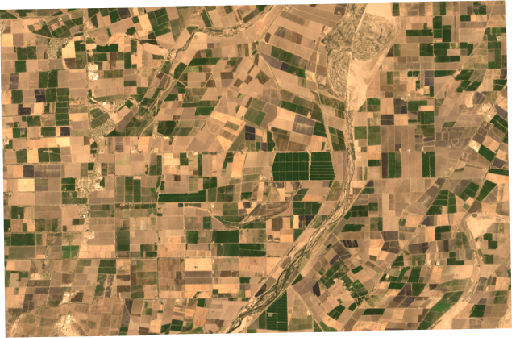

In [6]:
vis_image = ee.Image(landsat_img) \
    .visualize(bands=['B4', 'B3', 'B2'], min=[0, 0, 0], max=[3000, 3000, 3000]) \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .clip(test_geom)
Image(url=vis_image.getThumbURL(), embed=True, format='png')

### Prep the raw Landsat TOA image for use in DisALEXI

The prep function will rename the bands to generic names, compute albedo, ndvi, lai, and extract the fmask image from the BQA band.

In [7]:
input_img = ee.Image(landsat.LandsatSR(landsat_img).prep())

Show the NDVI band for the validation asset area

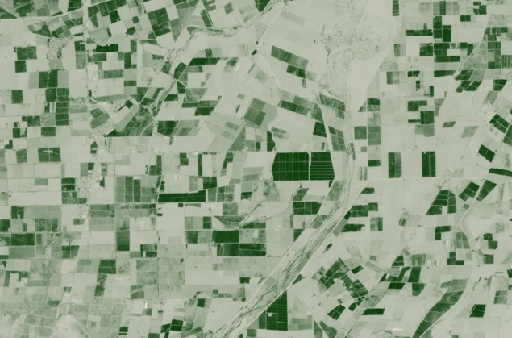

In [8]:
vis_img = input_img.select(['ndvi']).getThumbURL({
    'region': test_region, 'min':-0.1, 'max':0.9, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

Show the NDVI band for the test site area

In [9]:
# Image(url=input_img.select(['ndvi']).getThumbURL({
#         'region': test_region, 'min':-0.1, 'max':0.9, 'palette': ndvi_palette}),
#      embed=True, format='png')

### Extract input values at the test point

In [10]:
print('LAI:    {:12.8f}'.format(float(
    utils.image_value(input_img, xy=test_xy, scale=30)['lai'])))
print('NDVI:   {:12.8f}'.format(float(
    utils.image_value(input_img, xy=test_xy, scale=30)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(
    utils.image_value(input_img, xy=test_xy, scale=30)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(
    utils.image_value(input_img, xy=test_xy, scale=30)['lst'])))
print('CFMask: {:12.8f}'.format(float(
    utils.image_value(input_img, xy=test_xy, scale=30)['cfmask'])))

LAI:      3.62105965
NDVI:     0.80274796
Albedo:   0.21901540
LST:    308.30785437 [K]
CFMask:   0.00000000


### Initialize the DisALEXI object

In [11]:
# Initialize the DisALEXI object using all default values
# NLCD Landcover, NED Elevation, CONUS ALEXI ET
disalexi = disalexi.Image(
    input_img, 
    iterations=10,
    elevation=ee.Image('USGS/SRTMGL1_003').rename(['elevation']),
    landcover=ee.Image(
        ee.ImageCollection('users/cgmorton/GlobeLand30').mosaic()) \
            .divide(10).floor().multiply(10) \
            .rename(['landcover']),
    lc_type='GLOBELAND30')
disalexi._set_alexi_et_vars()
disalexi._set_elevation_vars()
disalexi._set_landcover_vars()
disalexi._set_time_vars()
disalexi._set_solar_vars()
disalexi._set_weather_vars()

### Extract the ancillary values at the test point

In [12]:
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.image_value(
    disalexi.alexi_et, xy=test_xy, scale=30)['alexi_et'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.image_value(
    disalexi.elevation, xy=test_xy, scale=30)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs1, xy=test_xy, scale=30)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs24, xy=test_xy, scale=30)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.image_value(
    disalexi.windspeed, xy=test_xy, scale=30)['windspeed'])))
print('Land Cover: {:3}'.format(int(utils.image_value(
    disalexi.landcover, xy=test_xy, scale=30)['landcover'])))

ALEXI ET:     2.62940478 [mm]
Elevation:   17.00000000 [m]
Rs Hourly:  929.51891667 [W m-2]
Rs Daily:  8239.91601562 [W m-2]
Wind Speed:   3.97250716 [m/s]
Land Cover:  10


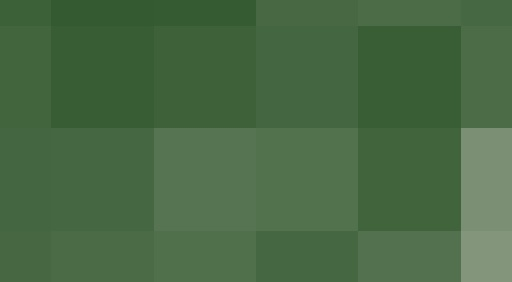

In [13]:
vis_img = disalexi.alexi_et.getThumbURL({
    'region': test_region, 'min':0, 'max':4, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

### Extract the computed inputs

In [14]:
print('hc:       {:12.8f}'.format(float(
    utils.image_value(disalexi.hc, xy=test_xy, scale=30)['hc'])))
print('clump:    {:12.8f}'.format(float(
    utils.image_value(disalexi.clump, xy=test_xy, scale=30)['omega'])))
print('t_rise:   {:12.8f}'.format(float(
    utils.image_value(disalexi.t_rise, xy=test_xy, scale=30)['t_rise'])))
print('t_end:    {:12.8f}'.format(float(
    utils.image_value(disalexi.t_end, xy=test_xy, scale=30)['t_end'])))
print('pressure: {:12.8f}'.format(float(
    utils.image_value(disalexi.pressure, xy=test_xy, scale=30)['pressure'])))

hc:         0.46648820
clump:      0.83000000
t_rise:    12.75206586
t_end:     26.78551224
pressure: 101.09921051


### Compute Air Temperature

In [15]:
image_transform = ee.Image(landsat_img).select('B2').projection().getInfo()['transform']
print(image_transform)

# Reduce the computation resolution
image_transform = '[' + ','.join(map(str, [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0])) + ']'
# output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
image_transform = [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]
print(image_transform)

[30.0, 0.0, 626985.0, 0.0, -30.0, 3629715.0]
[120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]


In [16]:
t_air_img = ee.Image(disalexi.compute_ta())\
    .reproject(crs=image_crs, crsTransform=image_transform)
print('Output Ta:\n{}'.format(pprint.pformat(
    utils.image_value(t_air_img, xy=test_xy, scale=30)['t_air'])))
print('Output Ta:\n{}'.format(pprint.pformat(
    utils.image_value(t_air_img, xy=test_xy, crs=image_crs, crsTransform=image_transform)['t_air'])))

Output Ta:
295.0
Output Ta:
295.0


In [17]:
t_air_url = t_air_img.getThumbURL({
    'region': test_region, 'min':270, 'max':330})
print(t_air_url)

https://earthengine.googleapis.com/api/thumb?thumbid=666d28d786efbb5769b11e4dfa88d8ec&token=5c4de874406ab99118c28733c430cfe7


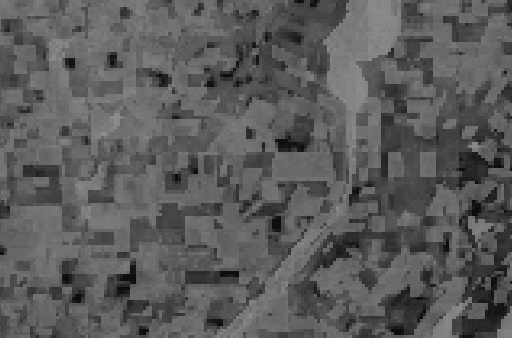

In [18]:
Image(url=t_air_url, embed=True, format='png')

### Aggregate Air Temperature to ALEXI ET cells

In [19]:
# Test asset ALEXI ET geotransform (from IDL)
# et_transform = [0.04, 0, -125.042123, 0, -0.04, 49.7764322]
# CONUS ALEXI ET geotransform
et_transform = [0.04, 0, -125.0, 0, -0.04, 49.80]

t_air_coarse_img = disalexi.aggregate(t_air_img) \
    .reproject(crs='EPSG:4326', crsTransform=et_transform)
print('Coarse Ta: {}'.format(pprint.pformat(
    utils.image_value(t_air_coarse_img, xy=test_xy, scale=30)['t_air'])))

Coarse Ta: 291.069831967866


In [20]:
t_air_coarse_url = t_air_coarse_img.getThumbUrl({
    'region': test_region, 'min':270, 'max':330})
print(t_air_coarse_url)

https://earthengine.googleapis.com/api/thumb?thumbid=ccdefd60cbe0492b849fdbe9ac12347c&token=43f4c5cd54ef5279d28a8ec9627b781b


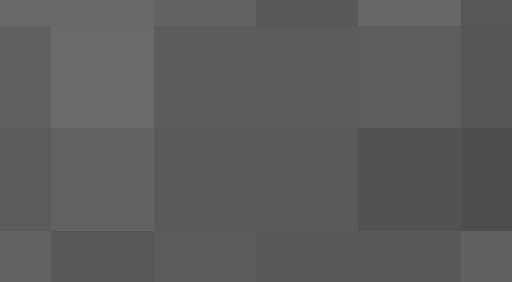

In [21]:
Image(url=t_air_coarse_url, embed=True, format='png')

### Compute ET

In [22]:
et_img = disalexi.compute_et(t_air_coarse_img) \
    .reproject(crs=image_crs, crsTransform=image_transform)
print('ET: {}'.format(pprint.pformat(
    utils.image_value(et_img, xy=test_xy, scale=30)['et'])))

ET: 1.2399115989162177


In [23]:
et_url = et_img.getThumbURL({
    'region': test_region, 'min': 1, 'max': 7, 
    'palette': ','.join(ssebop_et_palette)})
# print(et_url)

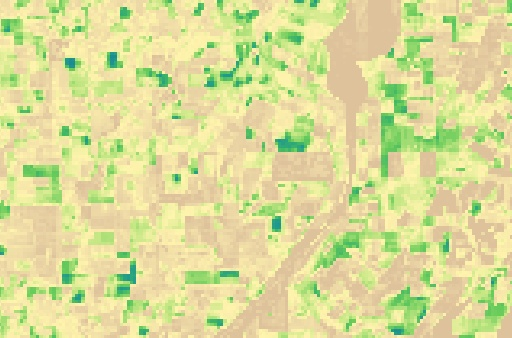

In [24]:
Image(url=et_url, embed=True, format='png')